In [461]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u
from yt.utilities.cosmology import Cosmology

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [12]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [281]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0110/halo_catalogs/catalog/catalog.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-28 10:43:25,964 Parameters: current_time              = 6.86908772332e+16
yt : [INFO     ] 2017-07-28 10:43:25,966 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-28 10:43:25,970 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-28 10:43:25,973 Parameters: domain_right_edge         = [  3.33803289e+25   3.33803289e+25   3.33803289e+25]
yt : [INFO     ] 2017-07-28 10:43:25,977 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-28 10:43:25,979 Parameters: current_redshift          = 2.9999999666
yt : [INFO     ] 2017-07-28 10:43:25,981 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-28 10:43:25,983 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-28 10:43:25,985 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-28 10:43:26,042 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-28 10:43:26,044 Parame

In [559]:
redshift_filename = './LG4_2048_40pc/rd0070/redshift0070'

# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# calculate current time
co = Cosmology(hubb_now.value, omega_m, cos_const)
time_now = co.hubble_time(redshift) * u.s

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [586]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load master calc lists
with open('./master_calc0030', 'rb') as infile:
    halo_list0030 = pickle.load(infile)
with open('./master_calc0050', 'rb') as infile:
    halo_list0050 = pickle.load(infile)
with open('./master_calc0070', 'rb') as infile:
    halo_list0070 = pickle.load(infile)
with open('./master_calc0090', 'rb') as infile:
    halo_list0090 = pickle.load(infile)
with open('./master_calc0110', 'rb') as infile:
    halo_list0110 = pickle.load(infile)

In [580]:
halo_list0030

[[2,
  6174,
  <Quantity 2627.5477718091106 kpc>,
  <Quantity 2544.1446953630893 kpc>,
  <Quantity 2566.9740712620464 kpc>,
  <Quantity 9060402645.837389 solMass>,
  <Quantity 8196059175.637566 solMass>,
  <Quantity 8.179926407820114 kpc>,
  <Quantity 12.047283394153846 kpc>,
  -1,
  <Quantity 1087224856.5641356 solMass>,
  <Quantity 179782332.00519875 solMass>,
  <Quantity 5095953707694528.0 s>,
  0.9926139823748812,
  <Quantity 0.6091408165211215 kpc>],
 [4,
  6173,
  <Quantity 2486.6782986976655 kpc>,
  <Quantity 2492.584062611104 kpc>,
  <Quantity 2981.286788305112 kpc>,
  <Quantity 7849008048.218473 solMass>,
  <Quantity 6300394697.621254 solMass>,
  <Quantity 7.797795148079457 kpc>,
  <Quantity 13.030727461646416 kpc>,
  -1,
  <Quantity 1133655153.3998017 solMass>,
  <Quantity 210727364.1386518 solMass>,
  <Quantity 5753502563457781.0 s>,
  4.089688143275694,
  <Quantity 2.0409231219985373 kpc>],
 [5,
  6172,
  <Quantity 2339.2488708306832 kpc>,
  <Quantity 2894.820385493461 kpc>

In [561]:
min_mass = 1e10 * u.Msun
mindex = 0

toSkip = (697, 825, 902, 914, 1111, 1211, 556)

count_agezero = 0
count_stelzero = 0
for halo in halo_list:
    mass = halo[5]
    rad = halo[7]
    stellar_mass = halo[11]
    ave_age = halo[12]
    
    if ave_age ==0:
        count_agezero +=1
    if stellar_mass == 0:
        count_stelzero +=1
    

count_agezero, count_stelzero, len(halo_list)

(9666, 9666, 11585)

In [588]:
toUse = "rd0030"

In [585]:
# pick halo list depending on toUse
if toUse == "rd0030":
    halo_list = halo_list0030
if toUse == "rd0050":
    halo_list = halo_list0050
if toUse == "rd0070":
    halo_list = halo_list0070
if toUse == "rd0090":
    halo_list = halo_list0090
if toUse == "rd0110":
    halo_list = halo_list0110
    
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
# masks used to limit Msun to 3e7-3e8, 3e8-3e9
gasratiolists = ([], [], [])
stelratiolists = ([], [], [])
agelists = ([], [], [])
proxlists = ([], [], [])
radratiolists = ([], [], [])
peaklists = ([], [], [])

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    gas_mass = halo[10]
    stellar_mass = halo[11]
    ave_age = halo[12]
    prox = halo[13]
    stel_rad = halo[14]
    
    print(halo_mass, stellar_mass2, ave_age)

    # check that not a satellite 
    if isSatellite >= 0:
        print('IsSat')
        continue
    
    # create bools for simplification
    isAgeZero = (ave_age == 0)
    isStelMassZero = (stellar_mass == 0)
    
    # find the ratios
    if not isStelMassZero:
        ratio1 = gas_mass.to('Msun') / halo_mass.to('Msun')
        ratio2 = stellar_mass.to('Msun') / halo_mass.to('Msun')
    else:
        ratio1 = 5e-4
        ratio2 = 5e-7
    
    rad_ratio = (stel_rad / radius).value
    peak_height = (prox * halo_mass) + halo_mass
    
    # set aside the rad ratio of 1
    if isStelMassZero:
        rad_ratio = 5e-4
    
    print(ratio1, ratio2)
    print(isAgeZero, isStelMassZero)
    
    # append those parameters that depend only on halo mass
    if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
        gasratiolists[0].append(ratio1)
        proxlists[0].append(prox)
        radratiolists[0].append(rad_ratio)
        peaklists[0].append(peak_height.value)
    if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
        gasratiolists[1].append(ratio1)
        proxlists[1].append(prox)
        radratiolists[1].append(rad_ratio)
        peaklists[1].append(peak_height.value)
    if halo_mass > 3e9 * u.Msun:
        gasratiolists[2].append(ratio1)
        proxlists[2].append(prox)
        radratiolists[2].append(rad_ratio)
        peaklists[2].append(peak_height.value)
    
    # append differently depending on ave_age == 0
    if isAgeZero and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(11)
            stelratiolists[0].append(ratio2)
            agelists[0].append(1e-1)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(12)
            stelratiolists[1].append(ratio2)
            agelists[1].append(1e-1)
        if halo_mass > 3e9 * u.Msun:
            print(13)
            stelratiolists[2].append(ratio2)
            agelists[2].append(1e-1)
    if isAgeZero and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(21)
            stelratiolists[0].append(5e-7)
            agelists[0].append(1e-1)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(22)
            stelratiolists[1].append(5e-7)
            agelists[1].append(1e-1)
        if halo_mass > 3e9 * u.Msun:
            print(23)
            stelratiolists[2].append(5e-7)
            agelists[2].append(1e-1)
    if (not isAgeZero) and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(31)
            stelratiolists[0].append(5e-7)
            agelists[0].append(ave_age.to('Myr').value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(32)
            stelratiolists[1].append(5e-7)
            agelists[1].append(ave_age.to('Myr').value)
        if halo_mass > 3e9 * u.Msun:
            print(33)
            stelratiolists[2].append(5e-7)
            agelists[2].append(ave_age.to('Myr').value)
    if (not isAgeZero) and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(4)
            stelratiolists[0].append(ratio2.value)
            agelists[0].append(ave_age.to('Myr').value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(5)
            stelratiolists[1].append(ratio2.value)
            agelists[1].append(ave_age.to('Myr').value)
        if halo_mass > 3e9 * u.Msun:
            print(6)
            stelratiolists[2].append(ratio2.value)
            agelists[2].append(ave_age.to('Myr').value)
            
# convert peaklist to arrays
peaklists[0] = np.array(peaklists[0])
peaklists[1] = np.array(peaklists[1])
peaklists[2] = np.array(peaklists[2])

# store lists in temp dict
tempdict = {"gasratio": gasratiolists, 
            "stelratio": stelratiolists,
            "age": agelists,
            "prox": proxlists,
            "radratio": radratiolists,
            "peak": peaklists}

# store dict depending on toUse
if toUse == "rd0030":
    lists0030 = tempdict
if toUse == "rd0050":
    lists0050 = tempdict
if toUse == "rd0070":
    lists0070 = tempdict
if toUse == "rd0090":
    lists0090 = tempdict
if toUse == "rd0110":
    lists0110 = tempdict

9060402645.837389 solMass 0 5095953707694528.0 s
0.11999741060775462 0.019842642654274968
False False
6
7849008048.218473 solMass 0 5753502563457781.0 s
0.1444329202410632 0.026847642765060176
False False
6
7399207108.754084 solMass 0 3617965343074710.5 s
0.13905587098187286 0.017773430337778156
False False
6
6012712815.028287 solMass 0 1862215628557441.0 s
0.16687955814564406 0.012952754806321945
False False
6
5308698775.584763 solMass 0 5498501305586913.0 s
0.170178699023267 0.04059452085953231
False False
6
5091044155.85847 solMass 0 4980803458496731.0 s
0.15086149902350682 0.023513364910740797
False False
6
4602954228.913103 solMass 0 4234330093470323.5 s
0.162255023348166 0.022605408040481372
False False
6
3811687379.60136 solMass 0 5977821045678439.0 s
0.16680356136719318 0.015933930227074258
False False
6
4450990193.589116 solMass 0 3044701690635589.5 s
0.19092361565599708 0.012946320932101097
False False
6
3948361569.5120573 solMass 0 4573367851751644.0 s
0.22155755316841985 0.

1008847385.9579287 solMass 0 1942294224720906.0 s
0.20160417072495845 0.0001340742322420422
False False
5
851267156.4830651 solMass 0 2958650921123309.5 s
0.2352776542241362 0.012213293223857174
False False
5
814287767.9131743 solMass 0 1115269949919524.4 s
0.24729640049806872 0.0023815311435285186
False False
5
820426008.8691033 solMass 0 1921643173370197.5 s
0.2044987514814905 0.000565269935043072
False False
5
869279061.5525221 solMass 0 2641603393782798.0 s
0.1864265532642677 0.0008242306391395544
False False
5
708469021.6372963 solMass 0 4603751679324788.0 s
0.2576067931834009 0.0025062042935206025
False False
5
794843089.0893139 solMass 0 2895699079452007.5 s
0.21078928941943278 0.006845905045563524
False False
5
815398982.6278459 solMass 0 2702637418269965.5 s
0.23216435674985078 2.1833580303664753e-05
False False
5
693759135.4745066 solMass 0 5396015592347174.0 s
0.24239989283547417 0.01694220754729357
False False
5
816794668.7920184 solMass 0 5072735771042442.0 s
0.21891206289

0.24168608375356596 0.0089360631810468
False False
5
477872341.48642 solMass 0 838243491107125.0 s
0.2739688032143952 0.0006183792938763485
False False
5
509706457.7961231 solMass 0 3211434158694932.0 s
0.21685168030504318 0.003138821803802975
False False
5
484825300.77280396 solMass 0 2987363528498750.5 s
0.2296879308103308 0.0006916826189047919
False False
5
454069210.4914255 solMass 0 5494484366930306.0 s
0.23934252005867016 0.001402161674044175
False False
5
435495876.28376937 solMass 0 612631956612228.6 s
0.2014003320098419 0.0002278230733399707
False False
5
491271912.51894987 solMass 0 0.0 s
0.0005 5e-07
True True
22
448487612.1389599 solMass 0 489423682643848.8 s
0.22879619644093901 0.000568442461752685
False False
5
494466025.14442706 solMass 0 1.0344719686315994e+16 s
0.09616538984552671 0.002171072271238345
False False
5
486776828.5956334 solMass 0 2261551514407612.5 s
0.21003363992795918 0.0022804500164363543
False False
5
381913975.9929425 solMass 0 5734108773389636.0 s
0.

305554427.1951002 solMass 0 2428391530638652.0 s
0.1707751220618608 0.0016880510004933617
False False
5
412038394.4530271 solMass 0 5916492189562378.0 s
0.12784234256395144 0.0007937303951194374
False False
5
247726417.38410637 solMass 0 1.0982707875384718e+16 s
0.21958233907469404 2.0799021320386163e-05
False False
4
329063741.8968679 solMass 0 5702621221490297.0 s
0.36395974171580847 6.263184156325103e-05
False False
5
423623846.8359575 solMass 0 1563348966828098.0 s
0.15779051698080301 6.081417600965475e-05
False False
5
265667436.67206132 solMass 0 3766390157084438.5 s
0.2970315213038665 0.011133306984828164
False False
4
334993253.80644274 solMass 0 69157230800376.48 s
0.11576950574063538 0.00036686922487653376
False False
5
281013408.57260966 solMass 0 1827098799241363.0 s
0.2054832690282332 0.002140777209340577
False False
4
209229983.35405025 solMass 0 2656423943143353.0 s
0.4887466655698873 0.012372852797441526
False False
4
265036045.62995657 solMass 0 1.1182311855838476e+16 

0.4094417056896384 0.0011193926173274677
False False
4
291200613.4899089 solMass 0 0.0 s
0.0005 5e-07
True True
21
298893923.49847573 solMass 0 0.0 s
0.0005 5e-07
True True
21
109795212.16346186 solMass 0 0.0 s
0.0005 5e-07
True True
21
342009962.1502347 solMass 0 2424395433447781.0 s
0.15213921995600554 0.0002787072036708499
False False
5
183863285.9029429 solMass 0 0.0 s
0.0005 5e-07
True True
21
170452992.51228404 solMass 0 6812938249018277.0 s
0.40819855647250985 4.534212301643047e-05
False False
4
209562728.67037618 solMass 0 3185805916646309.0 s
0.35022854090342936 0.007972053607211288
False False
4
245057060.8428819 solMass 0 0.0 s
0.0005 5e-07
True True
21
198608044.74224946 solMass 0 1382864556958167.0 s
0.19631502375245877 0.001709722669673078
False False
4
195255614.54768893 solMass 0 1726110883492504.2 s
0.3058059335918525 0.0016454634657384697
False False
4
229227841.94944695 solMass 0 4269996939114766.0 s
0.28353140442390556 0.0006974081578093068
False False
4
212298881.9

103559220.14768086 solMass 0 0.0 s
0.0005 5e-07
True True
21
163845268.73672867 solMass 0 0.0 s
0.0005 5e-07
True True
21
235720481.66385067 solMass 0 0.0 s
0.0005 5e-07
True True
21
136286435.0285118 solMass 0 6663949546565785.0 s
0.3730558788581911 0.017043314032708215
False False
4
97841103.3273395 solMass 0 2882606858861938.5 s
0.34763365213100766 0.0007372621123465673
False False
4
112091238.14285271 solMass 0 0.0 s
0.0005 5e-07
True True
21
130438957.79572755 solMass 0 0.0 s
0.0005 5e-07
True True
21
121066177.72938813 solMass 0 0.0 s
0.0005 5e-07
True True
21
126324468.8179161 solMass 0 0.0 s
0.0005 5e-07
True True
21
188752542.7403292 solMass 0 0.0 s
0.0005 5e-07
True True
21
106940408.76944447 solMass 0 0.0 s
0.0005 5e-07
True True
21
132732272.3247147 solMass 0 6249806278108116.0 s
0.39874241620357564 0.0026974273124488915
False False
4
83469904.02957726 solMass 0 0.0 s
0.0005 5e-07
True True
21
135406795.92828903 solMass 0 0.0 s
0.0005 5e-07
True True
21
126969212.50235546 s

92196376.7493491 solMass 0 1412928625576790.5 s
0.5098121432337495 0.010791356585370556
False False
4
85057111.02816676 solMass 0 0.0 s
0.0005 5e-07
True True
21
128753896.8035524 solMass 0 0.0 s
0.0005 5e-07
True True
21
154183526.64524806 solMass 0 0.0 s
0.0005 5e-07
True True
21
145313484.91836268 solMass 0 3401360031570819.0 s
0.1716834935497932 0.00438464179900166
False False
4
142648510.11135498 solMass 0 5938420194518408.0 s
0.17761324348609858 1.8060009994677286e-05
False False
4
136305836.3964484 solMass 0 0.0 s
0.0005 5e-07
True True
21
84406854.57835937 solMass 0 0.0 s
0.0005 5e-07
True True
21
175699314.10910273 solMass 0 0.0 s
0.0005 5e-07
True True
21
100364834.6000675 solMass 0 0.0 s
0.0005 5e-07
True True
21
129789199.2078232 solMass 0 0.0 s
0.0005 5e-07
True True
21
104362352.19778502 solMass 0 0.0 s
0.0005 5e-07
True True
21
114887615.05607662 solMass 0 0.0 s
0.0005 5e-07
True True
21
124442240.63495135 solMass 0 0.0 s
0.0005 5e-07
True True
21
81188307.86807047 solMa

True True
21
102383796.59689617 solMass 0 0.0 s
0.0005 5e-07
True True
21
74687031.81326604 solMass 0 0.0 s
0.0005 5e-07
True True
21
126870380.71625786 solMass 0 0.0 s
0.0005 5e-07
True True
21
95084403.73714466 solMass 0 0.0 s
0.0005 5e-07
True True
21
100348488.68444258 solMass 0 0.0 s
0.0005 5e-07
True True
21
153159938.72930837 solMass 0 0.0 s
0.0005 5e-07
True True
21
94270093.6159575 solMass 0 0.0 s
0.0005 5e-07
True True
21
61972490.59114279 solMass 0 0.0 s
0.0005 5e-07
True True
21
77915394.38762338 solMass 0 3402558531355206.5 s
0.34963086114784453 0.00013225799797766908
False False
4
108805457.09699236 solMass 0 0.0 s
0.0005 5e-07
True True
21
77270983.58242247 solMass 0 0.0 s
0.0005 5e-07
True True
21
87383392.8533918 solMass 0 0.0 s
0.0005 5e-07
True True
21
96450807.11882877 solMass 0 0.0 s
0.0005 5e-07
True True
21
104008327.40513176 solMass 0 0.0 s
0.0005 5e-07
True True
21
172228114.55420256 solMass 0 0.0 s
0.0005 5e-07
True True
21
105306247.707711 solMass 0 0.0 s
0.0

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


0.0005 5e-07
True True
94287578.7111244 solMass 0 0.0 s
0.0005 5e-07
True True
21
92892684.40107062 solMass 0 0.0 s
0.0005 5e-07
True True
21
66821371.754714005 solMass 0 0.0 s
0.0005 5e-07
True True
21
116753175.53753176 solMass 0 0.0 s
0.0005 5e-07
True True
21
111571267.03196742 solMass 0 0.0 s
0.0005 5e-07
True True
21
109408942.7951675 solMass 0 0.0 s
0.0005 5e-07
True True
21
80869973.58725752 solMass 0 0.0 s
0.0005 5e-07
True True
21
181854432.80788362 solMass 0 0.0 s
0.0005 5e-07
True True
21
63119022.6536687 solMass 0 0.0 s
0.0005 5e-07
True True
21
81859544.40239497 solMass 0 0.0 s
0.0005 5e-07
True True
21
69913682.32626304 solMass 0 0.0 s
0.0005 5e-07
True True
21
90619167.69387227 solMass 0 0.0 s
0.0005 5e-07
True True
21
56202803.59723288 solMass 0 0.0 s
0.0005 5e-07
True True
21
72131674.20246205 solMass 0 6930914737637934.0 s
0.4064732078951365 3.5715703909849936e-05
False False
4
125950404.78901456 solMass 0 0.0 s
0.0005 5e-07
True True
21
78295710.43448867 solMass 0 0

0.0005 5e-07
True True
21
64495104.53012868 solMass 0 1909822914597186.2 s
0.5497095628960627 0.00023966782010253966
False False
4
70378233.228888 solMass 0 0.0 s
0.0005 5e-07
True True
21
45598550.1130592 solMass 0 9248831650609214.0 s
0.642035034412274 0.0001129962909821392
False False
4
56625735.19524786 solMass 0 0.0 s
0.0005 5e-07
True True
21
69570947.09028794 solMass 0 0.0 s
0.0005 5e-07
True True
21
53314863.124258496 solMass 0 3960086351768047.5 s
0.4414579683482397 0.0002899266771818492
False False
4
26869571.988429 solMass 0 0.0 s
0.0005 5e-07
True True
111835188.46429224 solMass 0 0.0 s
0.0005 5e-07
True True
21
45691809.56869883 solMass 0 0.0 s
0.0005 5e-07
True True
21
72266976.82140328 solMass 0 3932393727355172.5 s
0.13486116237005205 0.0011268952442725281
False False
4
57061115.25441642 solMass 0 2975942133511163.0 s
0.3717305752054316 0.0006899573706579692
False False
4
83920332.20652092 solMass 0 0.0 s
0.0005 5e-07
True True
21
45301227.44071015 solMass 0 0.0 s
0.000

0.0005 5e-07
True True
21
95225790.56573913 solMass 0 0.0 s
0.0005 5e-07
True True
21
54003666.879726514 solMass 0 6924928171249692.0 s
0.4832184684759493 4.7704788715079605e-05
False False
4
69711838.82247813 solMass 0 0.0 s
0.0005 5e-07
True True
21
43345984.15269233 solMass 0 0.0 s
0.0005 5e-07
True True
21
73569859.45949279 solMass 0 0.0 s
0.0005 5e-07
True True
21
62191394.80859713 solMass 0 0.0 s
0.0005 5e-07
True True
21
53558776.013028614 solMass 0 0.0 s
0.0005 5e-07
True True
21
75119015.83399764 solMass 0 0.0 s
0.0005 5e-07
True True
21
70194821.34312303 solMass 0 0.0 s
0.0005 5e-07
True True
21
54261975.37730489 solMass 0 0.0 s
0.0005 5e-07
True True
21
49209256.170968 solMass 0 0.0 s
0.0005 5e-07
True True
21
67623814.08707257 solMass 0 0.0 s
0.0005 5e-07
True True
21
64321873.930038616 solMass 0 0.0 s
0.0005 5e-07
True True
21
60737343.36960767 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
49334176.89821468 solMass 0 0.0 s
0.0005 5e-07
Tr

0.0005 5e-07
True True
21
48857132.22004417 solMass 0 0.0 s
0.0005 5e-07
True True
21
39371079.67872094 solMass 0 0.0 s
0.0005 5e-07
True True
21
35347349.774721086 solMass 0 0.0 s
0.0005 5e-07
True True
21
43916990.91786901 solMass 0 0.0 s
0.0005 5e-07
True True
21
49712771.17311376 solMass 0 0.0 s
0.0005 5e-07
True True
21
60946249.77802755 solMass 0 0.0 s
0.0005 5e-07
True True
21
62356604.211751945 solMass 0 0.0 s
0.0005 5e-07
True True
21
53735997.39599396 solMass 0 0.0 s
0.0005 5e-07
True True
21
28956659.647750832 solMass 0 0.0 s
0.0005 5e-07
True True
43657112.9820348 solMass 0 0.0 s
0.0005 5e-07
True True
21
52105305.25829161 solMass 0 0.0 s
0.0005 5e-07
True True
21
61220156.1797383 solMass 0 0.0 s
0.0005 5e-07
True True
21
51670774.90111731 solMass 0 0.0 s
0.0005 5e-07
True True
21
36776901.173635684 solMass 0 0.0 s
0.0005 5e-07
True True
21
28083598.76051112 solMass 0 0.0 s
0.0005 5e-07
True True
43744214.383335195 solMass 0 4900828256838428.0 s
0.11928813288918932 0.005300

51889927.58691861 solMass 0 0.0 s
0.0005 5e-07
True True
21
41062333.25110638 solMass 0 0.0 s
0.0005 5e-07
True True
21
61849979.61015755 solMass 0 0.0 s
0.0005 5e-07
True True
21
32791343.53989613 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
37183742.33075294 solMass 0 0.0 s
0.0005 5e-07
True True
21
41007846.496668674 solMass 0 0.0 s
0.0005 5e-07
True True
21
44903103.94206091 solMass 0 0.0 s
0.0005 5e-07
True True
21
72876452.6932219 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
39742858.31005669 solMass 0 0.0 s
0.0005 5e-07
True True
21
21092038.04502938 solMass 0 4761711533785000.0 s
0.056251893309175106 0.008672115013799032
False False
44339789.56454785 solMass 0 0.0 s
0.0005 5e-07
True True
21
28778873.62657156 solMass 0 0.0 s
0.0005 5e-07
True True
20709874.7895171 solMass 0 0.0 s
0.0005 5e-07
True True
59322603.841783546 solMass 0 0.0 s
0.0005 5e-07
True True
21
38428972.27436917 solMass 0 0.0 s
0.0005 5e-0

39474414.166215226 solMass 0 0.0 s
0.0005 5e-07
True True
21
48774131.249922656 solMass 0 0.0 s
0.0005 5e-07
True True
21
33991751.10354692 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
26035186.779209986 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29667667.728497714 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22945104.690353785 solMass 0 0.0 s
0.0005 5e-07
True True
37214675.152729414 solMass 0 0.0 s
0.0005 5e-07
True True
21
25930551.57818948 solMass 0 0.0 s
0.0005 5e-07
True True
28864615.95603196 solMass 0 0.0 s
0.0005 5e-07
True True
30945447.766444158 solMass 0 0.0 s
0.0005 5e-07
True True
21
31194723.139787935 solMass 0 0.0 s
0.0005 5e-07
True True
21
44451768.240117565 solMass 0 0.0 s
0.0005 5e-07
True True
21
47000664.347255245 solMass 0 0.0 s
0.0005 5e-07
True True
21
26511919.783527736 solMass 0 0.0 s
0.0005 5e-07
True True
35130212.668079585 solMass 0 5705641527599281.0 s


0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
56218794.04185274 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35336215.3300725 solMass 0 0.0 s
0.0005 5e-07
True True
21
55328764.60716257 solMass 0 0.0 s
0.0005 5e-07
True True
21
47552204.16993268 solMass 0 0.0 s
0.0005 5e-07
True True
21
28515380.17328405 solMass 0 0.0 s
0.0005 5e-07
True True
36576703.302720286 solMass 0 0.0 s
0.0005 5e-07
True True
21
56142818.17814444 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31054554.607911043 solMass 0 0.0 s
0.0005 5e-07
True True
21
45920730.41431161 solMass 0 0.0 s
0.0005 5e-07
True True
21
43562094.95845016 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29877208.548916377 solMass 0 0.0 s
0.0005 5e-07
Tru

True True
70046485.4230966 solMass 0 0.0 s
0.0005 5e-07
True True
21
46261409.35328145 solMass 0 0.0 s
0.0005 5e-07
True True
21
27037125.839391153 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25706804.548602484 solMass 0 0.0 s
0.0005 5e-07
True True
28418696.460663423 solMass 0 0.0 s
0.0005 5e-07
True True
24656298.33046816 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31391248.667897135 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26614545.255827956 solMass 0 0.0 s
0.0005 5e-07
True True
37411937.472526215 solMass 0 0.0 s
0.0005 5e-07
True True
21
33004308.15725048 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
38806016.69739756 solMass 0 0.0 s
0.0005 5e-07
Tr

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25651738.761022635 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
55285914.0538433 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35539867.279170714 solMass 0 0.0 s
0.0005 5e-07
True True
21
26226963.951179575 solMass 0 0.0 s
0.0005 5e-07
True True
29173957.971718535 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34286913.24357813 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
31618785.921530046 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25530211.774839696 solMass 0 0.0 s
0.0005 5e-07
True True
30889683.805704318 s

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22717212.848500438 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29891643.03245692 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27860634.283725034 solMass 0 0.0 s
0.0005 5e-07
True True
27558581.79595114 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
40254343.41642722 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26079868.872135863 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 s

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30141378.03345659 solMass 0 0.0 s
0.0005 5e-07
True True
21
32510954.31710474 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22508982.52119824 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.00

0.2704842725348914 0.01032372100947616
False False
5
870499805.1474898 solMass 0 1746193879548926.2 s
0.2277888377036202 0.009142471428657564
False False
5
891273184.7606157 solMass 0 3155021367175790.5 s
0.3096034173589169 0.014226549818752899
False False
5
1012231745.4063956 solMass 0 4145091095504392.0 s
0.2045808630935423 0.000278834926206253
False False
5
971804398.1882341 solMass 0 3641557693268435.0 s
0.1981826019740304 0.0011113308058516742
False False
5
813526291.147164 solMass 0 4818367116547051.0 s
0.21735090784184408 0.008313051719732362
False False
5
763217297.3102597 solMass 0 2521181913075481.5 s
0.21658365466158336 0.0048459275338725415
False False
5
1064589953.4306662 solMass 0 655722154475231.1 s
0.18241923563413526 0.00018160755221455357
False False
5
813144019.9362814 solMass 0 2003666032572368.2 s
0.2062997835249974 0.004687818518894032
False False
5
776182171.4301603 solMass 0 3319302920042353.5 s
0.30553123776743846 0.030347799956004794
False False
5
764362849.00

0.22356558273599658 0.007805741202506684
False False
5
468039594.3541195 solMass 0 3562060313188225.5 s
0.26151559801810825 0.0035836809188137925
False False
5
421797530.4655443 solMass 0 3166088607005598.5 s
0.3424680650274911 0.0008920240713745681
False False
5
341051165.8642908 solMass 0 2925231448350827.5 s
0.2670999145934587 0.0005528330834409113
False False
5
373768775.2818044 solMass 0 9991925953780040.0 s
0.2525092328124494 0.00046869586453530157
False False
5
471310467.8639603 solMass 0 2405299492332770.0 s
0.2724843367484216 0.00038299160205379533
False False
5
456086282.1731081 solMass 0 5890124931930945.0 s
0.22146537287610568 0.004444040349455307
False False
5
458016664.0248801 solMass 0 1.2009431481404024e+16 s
0.2576263331177654 0.0005568511767270656
False False
5
426642407.0796988 solMass 0 2464463526529662.5 s
0.19422816106818055 0.0007397987068415733
False False
5
451289439.3903295 solMass 0 0.0 s
0.0005 5e-07
True True
22
531512835.3436557 solMass 0 0.0 s
0.0005 5e-0

442820489.94213367 solMass 0 0.0 s
0.0005 5e-07
True True
22
225331926.056871 solMass 0 5788759374703118.0 s
0.3274224210923246 0.0014014847322968962
False False
4
312696056.01186204 solMass 0 0.0 s
0.0005 5e-07
True True
22
255827381.43335858 solMass 0 0.0 s
0.0005 5e-07
True True
21
383163624.975537 solMass 0 2170245929463668.5 s
0.20164189057978577 4.8031711906405084e-05
False False
5
265176300.95397082 solMass 0 3893779459147678.5 s
0.4275541087762885 0.01722883019084627
False False
4
313104990.2773289 solMass 0 0.0 s
0.0005 5e-07
True True
22
284232040.08765346 solMass 0 3660516037304998.0 s
0.2622788449880564 5.4383035442642254e-05
False False
4
255611062.85240397 solMass 0 0.0 s
0.0005 5e-07
True True
21
240414791.21333796 solMass 0 8021860690760757.0 s
0.2658180836625999 0.0008241565524066568
False False
4
258694914.02294636 solMass 0 4152198398295120.0 s
0.2140095742440384 0.0003310788780747809
False False
4
240522769.71467742 solMass 0 0.0 s
0.0005 5e-07
True True
21
17053955

173635456.54042906 solMass 0 0.0 s
0.0005 5e-07
True True
21
173485656.7951353 solMass 0 1806523842812762.8 s
0.5992338981260553 0.003191282553165341
False False
4
208907477.12595424 solMass 0 0.0 s
0.0005 5e-07
True True
21
218476619.68186888 solMass 0 3414808176952100.0 s
0.27047490083905545 0.0005536539549472757
False False
4
267446752.3208251 solMass 0 0.0 s
0.0005 5e-07
True True
21
153428652.36128378 solMass 0 8429634970909813.0 s
0.4634870545488057 0.0015951530597758678
False False
4
163751818.3393125 solMass 0 0.0 s
0.0005 5e-07
True True
21
127383165.82134749 solMass 0 1.2919645580469734e+16 s
0.24806027263706265 0.0008763073649376343
False False
4
190297288.37419444 solMass 0 1659194622291974.8 s
0.28697730358624074 0.00012954546363267547
False False
4
209059020.16986886 solMass 0 954943132535732.4 s
0.4231319706035375 0.00011689056545597316
False False
4
187779322.45249644 solMass 0 2388603120315931.0 s
0.5403137108130683 0.002374576803542593
False False
4
182843081.58114627

184995826.70731014 solMass 0 0.0 s
0.0005 5e-07
True True
21
132141323.45358726 solMass 0 4914707696421057.0 s
0.31927644012025014 0.0005263932824006726
False False
4
140036325.42898363 solMass 0 0.0 s
0.0005 5e-07
True True
21
154437950.51855344 solMass 0 0.0 s
0.0005 5e-07
True True
21
264104303.4759837 solMass 0 0.0 s
0.0005 5e-07
True True
21
110631901.67615809 solMass 0 0.0 s
0.0005 5e-07
True True
21
178566995.76476622 solMass 0 0.0 s
0.0005 5e-07
True True
21
193297435.03497845 solMass 0 0.0 s
0.0005 5e-07
True True
21
216908137.10039514 solMass 0 1.1748123354368554e+16 s
0.1045000503711968 0.0007126243079975819
False False
4
130507943.93342242 solMass 0 2447634158681282.5 s
0.6252823321982147 0.0033998531472669287
False False
4
150214672.11395255 solMass 0 0.0 s
0.0005 5e-07
True True
21
146401843.2838932 solMass 0 2681392120293476.0 s
0.27762814524536994 0.0016036588255341172
False False
4
182692789.93569595 solMass 0 0.0 s
0.0005 5e-07
True True
21
82283770.83749703 solMass 0

132609176.53562671 solMass 0 0.0 s
0.0005 5e-07
True True
21
119101193.67778617 solMass 0 0.0 s
0.0005 5e-07
True True
21
62855942.01943902 solMass 0 8774131157577140.0 s
0.5165264144261882 0.00028690421382125073
False False
4
108816754.05502224 solMass 0 0.0 s
0.0005 5e-07
True True
21
72504237.72700578 solMass 0 0.0 s
0.0005 5e-07
True True
21
84171938.88754077 solMass 0 0.0 s
0.0005 5e-07
True True
21
81074384.94879071 solMass 0 0.0 s
0.0005 5e-07
True True
21
90341488.64985058 solMass 0 0.0 s
0.0005 5e-07
True True
21
94759103.51159592 solMass 0 0.0 s
0.0005 5e-07
True True
21
92549434.55608527 solMass 0 0.0 s
0.0005 5e-07
True True
21
145018102.71983716 solMass 0 0.0 s
0.0005 5e-07
True True
21
67577404.24539977 solMass 0 0.0 s
0.0005 5e-07
True True
21
48637863.50675522 solMass 0 0.0 s
0.0005 5e-07
True True
21
57432567.88273672 solMass 0 0
IsSat
101798557.70721388 solMass 0 0.0 s
0.0005 5e-07
True True
21
77373553.97085765 solMass 0 0.0 s
0.0005 5e-07
True True
21
91873495.79458

133849172.37963295 solMass 0 0.0 s
0.0005 5e-07
True True
21
61362116.81736878 solMass 0 0.0 s
0.0005 5e-07
True True
21
69053202.10829006 solMass 0 0.0 s
0.0005 5e-07
True True
21
64532297.38347063 solMass 0 0.0 s
0.0005 5e-07
True True
21
76276149.41662899 solMass 0 0.0 s
0.0005 5e-07
True True
21
68536684.1952688 solMass 0 0.0 s
0.0005 5e-07
True True
21
66545286.168330744 solMass 0 0.0 s
0.0005 5e-07
True True
21
53133370.160571285 solMass 0 0.0 s
0.0005 5e-07
True True
21
87059259.4711097 solMass 0 0.0 s
0.0005 5e-07
True True
21
71961506.83401199 solMass 0 0.0 s
0.0005 5e-07
True True
21
51364741.85518774 solMass 0 0.0 s
0.0005 5e-07
True True
21
52689419.919378385 solMass 0 0.0 s
0.0005 5e-07
True True
21
109046284.63404356 solMass 0 0.0 s
0.0005 5e-07
True True
21
38373423.434824795 solMass 0 0.0 s
0.0005 5e-07
True True
21
152059518.32535198 solMass 0 0.0 s
0.0005 5e-07
True True
21
117124022.72380166 solMass 0 0.0 s
0.0005 5e-07
True True
21
75817340.28735527 solMass 0 0.0 s


74673372.39081612 solMass 0 0.0 s
0.0005 5e-07
True True
21
32597501.026638918 solMass 0 0.0 s
0.0005 5e-07
True True
21
48914160.08621641 solMass 0 0.0 s
0.0005 5e-07
True True
21
57030939.79297785 solMass 0 0.0 s
0.0005 5e-07
True True
21
122917553.79175937 solMass 0 0.0 s
0.0005 5e-07
True True
21
59240807.364247404 solMass 0 0
IsSat
65827019.59786265 solMass 0 0.0 s
0.0005 5e-07
True True
21
25480848.89583413 solMass 0 0.0 s
0.0005 5e-07
True True
59224991.96526544 solMass 0 0.0 s
0.0005 5e-07
True True
21
60932971.24652266 solMass 0 0.0 s
0.0005 5e-07
True True
21
58168260.649716064 solMass 0 0.0 s
0.0005 5e-07
True True
21
36622475.58315385 solMass 0 0.0 s
0.0005 5e-07
True True
21
38196393.39392763 solMass 0 0.0 s
0.0005 5e-07
True True
21
69084487.6204611 solMass 0 0.0 s
0.0005 5e-07
True True
21
49454327.27845647 solMass 0 0.0 s
0.0005 5e-07
True True
21
82282074.5515546 solMass 0 0.0 s
0.0005 5e-07
True True
21
64251247.473094776 solMass 0 0.0 s
0.0005 5e-07
True True
21
6026

55206811.769605406 solMass 0 0.0 s
0.0005 5e-07
True True
21
34157816.82771361 solMass 0 0.0 s
0.0005 5e-07
True True
21
50487668.257580504 solMass 0 0.0 s
0.0005 5e-07
True True
21
66000187.919575945 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
55152871.2877175 solMass 0 0.0 s
0.0005 5e-07
True True
21
42863575.21012157 solMass 0 0.0 s
0.0005 5e-07
True True
21
38292127.879279576 solMass 0 0.0 s
0.0005 5e-07
True True
21
46952952.662353255 solMass 0 0.0 s
0.0005 5e-07
True True
21
42010996.25755582 solMass 0 0.0 s
0.0005 5e-07
True True
21
52761642.88375877 solMass 0 0.0 s
0.0005 5e-07
True True
21
44413604.77066658 solMass 0 0.0 s
0.0005 5e-07
True True
21
52830982.24838292 solMass 0 0.0 s
0.0005 5e-07
True True
21
59439452.986895494 solMass 0 0.0 s
0.0005 5e-07
True True
21
52949950.80384383 solMass 0 0.0 s
0.0005 5e-07
True True
21
46799758.83877455 solMass 0 0.0 s
0.0005 5e-07
True True
21
73005022.46161926 solMass 0 0.0 s
0.0005 5e-07
True True

0.0005 5e-07
True True
21
76148216.12164144 solMass 0 0.0 s
0.0005 5e-07
True True
21
50399855.3942589 solMass 0 0.0 s
0.0005 5e-07
True True
21
38907251.90398612 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
37088688.991653256 solMass 0 0.0 s
0.0005 5e-07
True True
21
42803642.925279506 solMass 0 0.0 s
0.0005 5e-07
True True
21
22615207.19597131 solMass 0 0.0 s
0.0005 5e-07
True True
61842158.38119813 solMass 0 0.0 s
0.0005 5e-07
True True
21
45580089.72832303 solMass 0 0
IsSat
39791072.942240044 solMass 0 0.0 s
0.0005 5e-07
True True
21
48224729.618991934 solMass 0 0.0 s
0.0005 5e-07
True True
21
36592054.68829932 solMass 0 0.0 s
0.0005 5e-07
True True
21
42407523.23481213 solMass 0 0.0 s
0.0005 5e-07
True True
21
47119771.81779258 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
45863831.9554502 solMass 0 0.0 s
0.0005 5e-07
True True
21
306

0.0005 5e-07
True True
42576328.25462847 solMass 0 0.0 s
0.0005 5e-07
True True
21
49465110.959147945 solMass 0 0.0 s
0.0005 5e-07
True True
21
36445274.2370468 solMass 0 0.0 s
0.0005 5e-07
True True
21
35382800.03194656 solMass 0 0.0 s
0.0005 5e-07
True True
21
40259338.76654154 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
31952126.22448189 solMass 0 0.0 s
0.0005 5e-07
True True
21
28461249.356041905 solMass 0 0.0 s
0.0005 5e-07
True True
27363676.380183574 solMass 0 0.0 s
0.0005 5e-07
True True
26510729.6698373 solMass 0 0.0 s
0.0005 5e-07
True True
32062279.05199987 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
44042157.92735252 solMass 0 0.0 s
0.0005 5e-07
True True
21
34993172.04667539 solMass 0 0.0 s
0.0005 5e-07
True True
21
33180126.897801857 solMass 0 0.0 s
0.0005 5e-07
True True
21
38401971.55448609 solMass 0 0.0 s
0.0005 5e-07
T

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24482113.264286984 solMass 0 0.0 s
0.0005 5e-07
True True
26039420.970824096 solMass 0 0.0 s
0.0005 5e-07
True True
40367603.99841689 solMass 0 0.0 s
0.0005 5e-07
True True
21
44145169.39310523 solMass 0 0.0 s
0.0005 5e-07
True True
21
20116935.090976775 solMass 0 0.0 s
0.0005 5e-07
True True
30504411.07076279 solMass 0 0.0 s
0.0005 5e-07
True True
21
26521828.49979582 solMass 0 0.0 s
0.0005 5e-07
True True
26228407.672492255 solMass 0 0.0 s
0.0005 5e-07
True True
34547420.59234358 solMass 0 0.0 s
0.0005 5e-07
True True
21
41809394.41764925 solMass 0 0.0 s
0.0005 5e-07
True True
21
38918161.30393057 solMass 0 0.0 s
0.0005 5e-07
True True
21
33017749.88934042 solMass 0 0.0 s
0.0005 5e-07
True True
21
31741591.84961515 solMass 0 0.0 s
0.0005 5e-07
True True
21
27454581.292662874 solMass 0 0.0 s
0.0005 5e-07
True True
30361054.14163639

24442986.285456024 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31540973.28757938 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32708791.150868632 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
25273076.721745897 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23259338.602431186 solMass 0 0.0 s
0.0005 5e-07
True True
35544000.43354325 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
33740697.411937416 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29375509.76302952 solMass 0 0.0 s
0.0005 5e-07
True True
25586245.111793384 solMass 0 0.0 s
0.0005 5e-07
True True
0

31124384.99052568 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
38986307.53018541 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
28918409.316342026 solMass 0 0.0 s
0.0005 5e-07
True True
34160725.00704112 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
22867842.786678463 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35428101.66813753 solMass 0 0.0 s
0.0005 5e-07
True True
21
49589079.979486495 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
24655031.44042847 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24578831.964317665 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23799586.131487515 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 s

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32957525.275634877 solMass 0 0.0 s
0.0005 5e-07
True True
21
36909454.678587146 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34202198.324754484 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24362149.578122623 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24869197.10485998 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22909317.504436187 solMass 0 0.0 s
0.0005 5e-07
True True
30534947506.997288 solMass 0 0
IsSat
18238996443.60614 solMass 0 0
IsSat
11858790459.252502 solMass 0 0
IsSat
11322473726.94295 solMass 0 4393097844252702.0 s
0.15616328197361792 0.05033028118270594
False False
6
11499114329.642673 solMass 0 0
IsSat
8558943409.516756 solMass 0 5091050005245399.0 s
0.17495109016211194 0.028857062201084888
False False
6
7706477534.435364 solMass 0 0
IsSat
6881956128.822881 solMass 0 0
IsSat
3727612924.8312798 solMass 0 2555492911935495.0 s
0.19062767328087726 0.014757350028071981
False False
6
4127362106.236512 solMass 0 4030104335556911.0 s
0.19625235143996703 0.020637410762331585
False False
6
3299237212.108931 solMass 0 0
IsSat
2881210275.2430077 solMass 0 2220668330695501.0 s
0.19321132512014835 0.0183

193782629.4941771 solMass 0 2774154487784280.5 s
0.36702413733233324 0.000700628834122309
False False
4
332563101.5481994 solMass 0 9132682074877614.0 s
0.16642420361261182 1.5493201178386076e-05
False False
0.21338766684055238 0.0013621677407990595
False False
4
348275553.2092564 solMass 0 1222767046131297.8 s
0.12143045218344359 0.0001665914501158467
False False
5
185568708.98752272 solMass 0 1529268452139891.5 s
0.37927895305426657 2.77658181971525e-05
False False
4
199535945.93360886 solMass 0 4620195877678598.0 s
0.3368579990762841 0.0004041892071569917
False False
4
234039015.31464794 solMass 0 0.0 s
0.0005 5e-07
True True
21
218120361.1281928 solMass 0 0.0 s
0.0005 5e-07
True True
21
190626264.7705666 solMass 0 1.1740211823210796e+16 s
0.2513644069012313 0.001088775979577225
False False
4
208749127.81354362 solMass 0 0.0 s
0.0005 5e-07
True True
21
204769581.12549642 solMass 0 0.0 s
0.0005 5e-07
True True
21
164304801.34033984 solMass 0 2999187665432913.0 s
0.28519918584834697 0

1.0597732912911741 0.012583590751022696
False False
4
118303368.81667052 solMass 0 0.0 s
0.0005 5e-07
True True
21
106766323.05162247 solMass 0 0.0 s
0.0005 5e-07
True True
21
70058047.42631541 solMass 0 0.0 s
0.0005 5e-07
True True
21
87927782.71490511 solMass 0 0.0 s
0.0005 5e-07
True True
21
63052986.017471075 solMass 0 0.0 s
0.0005 5e-07
True True
21
98848283.53711572 solMass 0 0.0 s
0.0005 5e-07
True True
21
101243605.67806001 solMass 0 0.0 s
0.0005 5e-07
True True
21
53472557.83479266 solMass 0 1044953025653177.1 s
0.6312532701009804 0.0001009747940805315
False False
4
57604809.37371837 solMass 0 1.161233088811544e+16 s
0.018478521348701104 0.005098369811429957
False False
4
74005532.19338739 solMass 0 0.0 s
0.0005 5e-07
True True
21
111911348.4620802 solMass 0 0.0 s
0.0005 5e-07
True True
21
101308588.91302423 solMass 0 0.0 s
0.0005 5e-07
True True
21
98166184.48725845 solMass 0 1291330890385380.0 s
0.25403759096604034 2.671520554119488e-05
False False
4
103121768.70029558 solMa

0.0005 5e-07
True True
21
65731265.6019164 solMass 0 0.0 s
0.0005 5e-07
True True
21
62558722.99630724 solMass 0 0.0 s
0.0005 5e-07
True True
21
35886020.831691325 solMass 0 0.0 s
0.0005 5e-07
True True
21
124605588.09547278 solMass 0 0.0 s
0.0005 5e-07
True True
21
50799145.96246734 solMass 0 0.0 s
0.0005 5e-07
True True
21
68143716.43088675 solMass 0 0.0 s
0.0005 5e-07
True True
21
51432981.54133153 solMass 0 0.0 s
0.0005 5e-07
True True
21
52942006.33995253 solMass 0 0.0 s
0.0005 5e-07
True True
21
50281136.9397262 solMass 0 0.0 s
0.0005 5e-07
True True
21
72263901.8124936 solMass 0 0.0 s
0.0005 5e-07
True True
21
89280261.88071042 solMass 0 5149127171543990.0 s
0.059597278407931165 0.005742259927899434
False False
4
52707322.220543586 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
60229834.7638799 solMass 0 0.0 s
0.0005 5e-07
True True
21
74838467.1723177 solMass 0 0.0 s
0.0005 5e-07
True True
21
68072598.49465474 solMass 0 0.0 s
0.0005 5e-07
True 

24677580.68546295 solMass 0 0.0 s
0.0005 5e-07
True True
39832073.48020241 solMass 0 0.0 s
0.0005 5e-07
True True
21
39862000.635328084 solMass 0 0.0 s
0.0005 5e-07
True True
21
37398797.38329083 solMass 0 0.0 s
0.0005 5e-07
True True
21
39257373.744313434 solMass 0 0.0 s
0.0005 5e-07
True True
21
36093103.50316071 solMass 0 0.0 s
0.0005 5e-07
True True
21
60415648.92035535 solMass 0 0.0 s
0.0005 5e-07
True True
21
36686058.328346185 solMass 0 0.0 s
0.0005 5e-07
True True
21
42889395.13567408 solMass 0 3462328280762461.0 s
0.34729945993916606 0.0073443547615162
False False
4
52407306.22607667 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
65411070.398811996 solMass 0 0.0 s
0.0005 5e-07
True True
21
40294047.89126087 solMass 0 0.0 s
0.0005 5e-07
True True
21
39148552.65889929 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
66950838.23987411 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True


True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27650185.070840847 solMass 0 0.0 s
0.0005 5e-07
True True
25936615.320930116 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
40064689.46104763 solMass 0 0.0 s
0.0005 5e-07
True True
21
22400115.50388146 solMass 0 0.0 s
0.0005 5e-07
True True
24113409.29307334 solMass 0 0.0 s
0.0005 5e-07
True True
22461662.208213683 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
33814724.762069575 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29479657.519108336 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27787258.319162883 solMass 0 0.0 s
0.0005 5e-07
True

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28123913.26524058 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34018916.74584395 solMass 0 0.0 s
0.0005 5e-07
True True
21
24656888.385763604 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22443035.578099456 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24622748.44085043 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26294976.359593894 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
452134603.5132865 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 s

22265767.02275762 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 sol

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
Tru

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20279553905.301

False False
5
976831595.0860385 solMass 0 2726274445672165.5 s
0.2676814683145011 0.012426149929045446
False False
5
855013303.237199 solMass 0 3835486575480238.5 s
0.3005151094359771 0.004197941780510324
False False
5
880441654.0747085 solMass 0 4362434128322726.5 s
0.25112639563302086 0.011810054561109907
False False
5
862935073.5364081 solMass 0 2075322788610110.0 s
0.20955490605000024 0.00015281353163078078
False False
5
677776453.8534329 solMass 0 5928852752856304.0 s
0.2635104406538004 0.01731363650873956
False False
5
966125742.5273006 solMass 0 5139535014055196.0 s
0.23109419479585083 0.012826219603079917
False False
5
1205475822.3890886 solMass 0 1810330241848934.2 s
0.17768376249914616 5.173944797939522e-05
False False
5
1040047306.4764318 solMass 0 2589817599327152.5 s
0.17274780267641934 0.0003083464848708129
False False
5
876004323.1036137 solMass 0 3247361081046483.0 s
0.1979323242432932 0.008371604253881662
False False
5
885334092.8164943 solMass 0 4167315653107202.5 s
0

464633214.32693785 solMass 0 4035777420660106.0 s
0.2660211067484569 0.008375731754856832
False False
5
533138023.6369184 solMass 0 3442957517502276.5 s
0.3272831680533484 0.0012063220575829036
False False
5
492407101.43596864 solMass 0 3100576544187967.0 s
0.242526808898913 0.00042451181203806453
False False
5
531045437.10269344 solMass 0 1846347196790226.0 s
0.36548551882019276 0.009897977214535232
False False
5
575484459.2635235 solMass 0 1299621753550182.8 s
0.14836655916026972 8.484313563866117e-05
False False
5
501267737.1279106 solMass 0 2340336278731711.5 s
0.190613694528067 0.000277719809194285
False False
5
481949759.9330374 solMass 0 2400333761604133.0 s
0.18964572134170646 0.0008534170729297655
False False
5
643629622.7094066 solMass 0 1119857992658181.5 s
0.15760260460256711 5.119689533280834e-05
False False
5
400487779.20988995 solMass 0 9650439696312718.0 s
0.3613543245160079 0.002216797369681664
False False
5
675560803.9775227 solMass 0 1838863407663360.0 s
0.2124043345

0.24683790260179014 0.000580039919986353
False False
5
291616603.36709774 solMass 0 2038672889817890.5 s
0.31543534552565666 0.0015925086771105697
False False
4
330911504.43547094 solMass 0 0.0 s
0.0005 5e-07
True True
22
331199881.4910109 solMass 0 7230818724037578.0 s
0.35481053351823005 0.0020017294884934265
False False
5
433765293.7442136 solMass 0 2012348901729198.2 s
0.22389212866182467 0.0004668933698189539
False False
5
327902720.1452086 solMass 0 3541047504687577.5 s
0.23876410933722553 0.0026431495986662047
False False
5
303042907.53335106 solMass 0 0.0 s
0.0005 5e-07
True True
22
276906618.32225466 solMass 0 5062677973757168.0 s
0.26966589201131996 0.000526519933213262
False False
4
403633940.60863703 solMass 0 1866506385616035.0 s
0.219408385859858 0.00036668936413107573
False False
5
466992707.7317542 solMass 0 0.0 s
0.0005 5e-07
True True
22
380092164.46427023 solMass 0 1.2270907742532714e+16 s
0.13887156197021824 0.00042834866361660237
False False
5
325494706.729185 solM

0.20182764706148332 0.00011401743214170706
False False
5
225453298.5973957 solMass 0 801030081139835.0 s
0.27446681235301945 6.30896053674587e-05
False False
4
266779781.54371455 solMass 0 3411888880705278.0 s
0.15904123259431746 1.9313558947317324e-05
False False
4
245486583.14239937 solMass 0 4242109986775338.5 s
0.2494594827188762 0.0022281890555501714
False False
4
264671834.29610685 solMass 0 2119083340903778.0 s
0.18147779261043853 0.00020510716276422877
False False
4
182011147.02070895 solMass 0 1088447483179504.0 s
0.2945671983228226 1.5002127549966955e-05
False False
4
238744838.5787966 solMass 0 3267982961213707.5 s
0.27320258637149797 0.003079791264327884
False False
4
224512943.2068124 solMass 0 0.0 s
0.0005 5e-07
True True
21
199204684.5769907 solMass 0 2436489317419616.0 s
0.42749768210317923 0.004252273508527638
False False
4
254431603.55981234 solMass 0 1083415862952884.0 s
0.18007312834030828 1.0671325073828063e-05
False False
4
205290044.13437885 solMass 0 12295451085

True True
21
136065090.00677377 solMass 0 6990252485566358.0 s
0.42140095597773414 0.0008376252756209574
False False
4
269111655.5447 solMass 0 0.0 s
0.0005 5e-07
True True
21
187584653.0506932 solMass 0 0.0 s
0.0005 5e-07
True True
21
173358316.8191516 solMass 0 988982157797432.9 s
0.4456505647693365 0.00037882344886692657
False False
4
143013387.99201047 solMass 0 3548948580995258.0 s
0.6256104665090725 0.006524244075975119
False False
4
190913300.40085912 solMass 0 0.0 s
0.0005 5e-07
True True
21
210767979.43177631 solMass 0 0.0 s
0.0005 5e-07
True True
21
176901120.70994973 solMass 0 2817190720732012.0 s
0.4954712239479947 0.0009281197670292752
False False
4
199997363.2001347 solMass 0 8367179670699427.0 s
0.26037364095614046 0.002062030975072299
False False
4
176447919.20429686 solMass 0 982003984951428.2 s
0.29626173417613694 0.00010911304605330604
False False
4
167559953.60381028 solMass 0 2473155242685495.5 s
0.35966421845726637 0.006409921608750341
False False
4
178031729.4550

114438110.54786232 solMass 0 0.0 s
0.0005 5e-07
True True
21
122713072.0661624 solMass 0 1411440754832106.5 s
0.3969956739684225 0.00026802450222694515
False False
4
161164476.4541288 solMass 0 0.0 s
0.0005 5e-07
True True
21
147065223.4082542 solMass 0 0.0 s
0.0005 5e-07
True True
21
156586614.72208464 solMass 0 0.0 s
0.0005 5e-07
True True
21
177073241.93457973 solMass 0 0.0 s
0.0005 5e-07
True True
21
163462587.4359196 solMass 0 0.0 s
0.0005 5e-07
True True
21
141577296.05702132 solMass 0 5296442990345264.0 s
0.32769970798415715 0.00014557325729545902
False False
4
145151046.28113395 solMass 0 5320078709015345.0 s
0.3771766513185885 0.006292531487110358
False False
4
146525974.45516685 solMass 0 0.0 s
0.0005 5e-07
True True
21
110204665.80292062 solMass 0 6330877206426482.0 s
0.33458037225756593 0.010458718075756717
False False
4
126212787.26907812 solMass 0 0.0 s
0.0005 5e-07
True True
21
166337597.31973746 solMass 0 2907883060021057.5 s
0.1672027753288863 0.00027016107829981714
Fa

98775258.98732321 solMass 0 2700635872959808.5 s
0.6268860886024336 0.00010432707723815206
False False
4
117205949.81621195 solMass 0 0.0 s
0.0005 5e-07
True True
21
106589264.9609496 solMass 0 0.0 s
0.0005 5e-07
True True
21
116135977.98374422 solMass 0 2079375464744940.5 s
0.37855677997450443 0.0008829392008652611
False False
4
25456200.237240497 solMass 0 0.0 s
0.0005 5e-07
True True
84361068.38935605 solMass 0 3296023091105625.5 s
0.3746952990386286 0.0003053818031739883
False False
4
93794530.97477493 solMass 0 0.0 s
0.0005 5e-07
True True
21
115776810.03728002 solMass 0 0.0 s
0.0005 5e-07
True True
21
95896942.69343299 solMass 0 0.0 s
0.0005 5e-07
True True
21
144697879.84750462 solMass 0 0.0 s
0.0005 5e-07
True True
21
162716857.30811852 solMass 0 0.0 s
0.0005 5e-07
True True
21
31795610.840678032 solMass 0 0.0 s
0.0005 5e-07
True True
21
130742555.0284004 solMass 0 0.0 s
0.0005 5e-07
True True
21
98800842.97194399 solMass 0 2769989848972243.5 s
0.43045597772353866 0.01209794815

106224223.74579199 solMass 0 0.0 s
0.0005 5e-07
True True
21
65605179.98349471 solMass 0 0.0 s
0.0005 5e-07
True True
21
116178207.49050573 solMass 0 0.0 s
0.0005 5e-07
True True
21
102929002.83169074 solMass 0 0.0 s
0.0005 5e-07
True True
21
91843181.47033359 solMass 0 652554717183532.5 s
0.29085549949820977 0.0003060536309245545
False False
4
110002262.89188422 solMass 0 0.0 s
0.0005 5e-07
True True
21
92345072.11253606 solMass 0 0.0 s
0.0005 5e-07
True True
21
92733377.72535151 solMass 0 1084980994627856.0 s
0.39630187762641167 2.9112389997908024e-05
False False
4
62727079.48202838 solMass 0 0.0 s
0.0005 5e-07
True True
21
74954477.0539706 solMass 0 0.0 s
0.0005 5e-07
True True
21
103308275.02150477 solMass 0 3963336056034604.5 s
0.21245276051217377 0.005766888951786653
False False
4
43361397.49194288 solMass 0 0.0 s
0.0005 5e-07
True True
21
121245388.63351819 solMass 0 0.0 s
0.0005 5e-07
True True
21
144390857.04290164 solMass 0 0.0 s
0.0005 5e-07
True True
21
103667081.16854703 s

88979535.70074125 solMass 0 0.0 s
0.0005 5e-07
True True
21
86194608.68768112 solMass 0 0.0 s
0.0005 5e-07
True True
21
110469775.14652795 solMass 0 0.0 s
0.0005 5e-07
True True
21
85617766.27257746 solMass 0 0.0 s
0.0005 5e-07
True True
21
98467947.60043444 solMass 0 0.0 s
0.0005 5e-07
True True
21
98268616.82539077 solMass 0 0.0 s
0.0005 5e-07
True True
21
86232866.95158881 solMass 0 2805124591520351.5 s
0.15130533497985668 0.0020487439426712132
False False
4
68340555.92301872 solMass 0 0.0 s
0.0005 5e-07
True True
21
112574677.8268936 solMass 0 0.0 s
0.0005 5e-07
True True
21
93574763.8838964 solMass 0 0.0 s
0.0005 5e-07
True True
21
99249082.30822387 solMass 0 0.0 s
0.0005 5e-07
True True
21
79379573.6242314 solMass 0 0.0 s
0.0005 5e-07
True True
21
65686294.81324507 solMass 0 0.0 s
0.0005 5e-07
True True
21
90816662.24319805 solMass 0 0.0 s
0.0005 5e-07
True True
21
64748520.97945015 solMass 0 0.0 s
0.0005 5e-07
True True
21
39977501.13963297 solMass 0 0.0 s
0.0005 5e-07
True True

70877319.94676554 solMass 0 0.0 s
0.0005 5e-07
True True
21
73083564.80585079 solMass 0 1084863053224453.9 s
0.33840167850954955 7.345723139850187e-05
False False
4
77542575.05500531 solMass 0 0.0 s
0.0005 5e-07
True True
21
68621554.48487025 solMass 0 7705364976245484.0 s
0.31240691036319007 0.00037542628373275094
False False
4
89822948.82949762 solMass 0 0.0 s
0.0005 5e-07
True True
21
65959343.79567946 solMass 0 0.0 s
0.0005 5e-07
True True
21
45963049.80036184 solMass 0 0.0 s
0.0005 5e-07
True True
21
85709867.95006767 solMass 0 0.0 s
0.0005 5e-07
True True
21
79231597.15660046 solMass 0 0.0 s
0.0005 5e-07
True True
21
32264567.20390057 solMass 0 0.0 s
0.0005 5e-07
True True
21
66069332.24549 solMass 0 0.0 s
0.0005 5e-07
True True
21
48909094.316509716 solMass 0 0.0 s
0.0005 5e-07
True True
21
79369052.31094106 solMass 0 0.0 s
0.0005 5e-07
True True
21
82305598.15458304 solMass 0 0.0 s
0.0005 5e-07
True True
21
58708808.41150549 solMass 0 0.0 s
0.0005 5e-07
True True
21
87228132.58

64570860.16994786 solMass 0 0.0 s
0.0005 5e-07
True True
21
56831744.488129206 solMass 0 0.0 s
0.0005 5e-07
True True
21
62263017.66819361 solMass 0 0.0 s
0.0005 5e-07
True True
21
123301369.04033493 solMass 0 0.0 s
0.0005 5e-07
True True
21
25903648.716418248 solMass 0 0.0 s
0.0005 5e-07
True True
36702019.19117569 solMass 0 0.0 s
0.0005 5e-07
True True
21
35664643.140263915 solMass 0 0.0 s
0.0005 5e-07
True True
21
73578520.18648428 solMass 0 0.0 s
0.0005 5e-07
True True
21
118894756.76987799 solMass 0 0.0 s
0.0005 5e-07
True True
21
65252846.174980715 solMass 0 0.0 s
0.0005 5e-07
True True
21
52913023.38290782 solMass 0 0.0 s
0.0005 5e-07
True True
21
80472246.38498577 solMass 0 0.0 s
0.0005 5e-07
True True
21
96207318.4706348 solMass 0 0.0 s
0.0005 5e-07
True True
21
69398776.3216565 solMass 0 0.0 s
0.0005 5e-07
True True
21
57149642.2445424 solMass 0 0.0 s
0.0005 5e-07
True True
21
62096014.24818919 solMass 0 0.0 s
0.0005 5e-07
True True
21
109707293.10809223 solMass 0 0.0 s
0.000

True True
21
59705662.53092018 solMass 0 0.0 s
0.0005 5e-07
True True
21
50111195.2283136 solMass 0 0.0 s
0.0005 5e-07
True True
21
43006308.259676665 solMass 0 0.0 s
0.0005 5e-07
True True
21
50296027.73134103 solMass 0 0.0 s
0.0005 5e-07
True True
21
46056949.908704065 solMass 0 0.0 s
0.0005 5e-07
True True
21
55187468.131883785 solMass 0 0
IsSat
72237099.80743888 solMass 0 0.0 s
0.0005 5e-07
True True
21
77374160.7701419 solMass 0 0.0 s
0.0005 5e-07
True True
21
39436206.43115575 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
52993157.033587374 solMass 0 0.0 s
0.0005 5e-07
True True
21
51845382.16483814 solMass 0 0.0 s
0.0005 5e-07
True True
21
46930456.71572575 solMass 0 0.0 s
0.0005 5e-07
True True
21
40871923.70580015 solMass 0 0.0 s
0.0005 5e-07
True True
21
40512918.188095324 solMass 0 0.0 s
0.0005 5e-07
True True
21
70069690.18013859 solMass 0 0.0 s
0.0005 5e-07
True True
21
55859962.624706216 solMass 0 0.0 s
0.0005 5e-07
True True
21
49165285

False False
4
0.0 solMass 0 0
0.0005 5e-07
True True
28819061.791686196 solMass 0 0.0 s
0.0005 5e-07
True True
36237771.21606994 solMass 0 0.0 s
0.0005 5e-07
True True
21
40430460.82229784 solMass 0 0.0 s
0.0005 5e-07
True True
21
47408613.931565024 solMass 0 0.0 s
0.0005 5e-07
True True
21
36611013.3034177 solMass 0 0.0 s
0.0005 5e-07
True True
21
24380543.410980966 solMass 0 0.0 s
0.0005 5e-07
True True
56233535.85557279 solMass 0 0.0 s
0.0005 5e-07
True True
21
45390394.98552232 solMass 0 0.0 s
0.0005 5e-07
True True
21
37884213.66893781 solMass 0 0.0 s
0.0005 5e-07
True True
21
32983702.01217698 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
51710789.463644505 solMass 0 0.0 s
0.0005 5e-07
True True
21
61950392.13459689 solMass 0 0.0 s
0.0005 5e-07
True True
21
56874053.06268904 solMass 0 0.0 s
0.0005 5e-07
True True
21
48908223.30327

20731418.788190406 solMass 0 0.0 s
0.0005 5e-07
True True
36992319.62727618 solMass 0 0.0 s
0.0005 5e-07
True True
21
36488746.25872588 solMass 0 0.0 s
0.0005 5e-07
True True
21
58294748.49834266 solMass 0 0.0 s
0.0005 5e-07
True True
21
52654732.25049752 solMass 0 0.0 s
0.0005 5e-07
True True
21
28437594.285501342 solMass 0 0.0 s
0.0005 5e-07
True True
23746439.20160771 solMass 0 0.0 s
0.0005 5e-07
True True
44598726.35374115 solMass 0 0.0 s
0.0005 5e-07
True True
21
59890200.63155966 solMass 0 0.0 s
0.0005 5e-07
True True
21
62941859.56777778 solMass 0 0.0 s
0.0005 5e-07
True True
21
21890357.149651445 solMass 0 0.0 s
0.0005 5e-07
True True
37513635.65262427 solMass 0 0.0 s
0.0005 5e-07
True True
21
59334508.15592786 solMass 0 0.0 s
0.0005 5e-07
True True
21
21344319.72642917 solMass 0 0.0 s
0.0005 5e-07
True True
32929597.876038507 solMass 0 0.0 s
0.0005 5e-07
True True
21
22962458.2308975 solMass 0 0.0 s
0.0005 5e-07
True True
47175106.383497395 solMass 0 0.0 s
0.0005 5e-07
True Tr

31165979.150441498 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
42707030.521269955 solMass 0 0.0 s
0.0005 5e-07
True True
21
29579291.098169494 solMass 0 0.0 s
0.0005 5e-07
True True
29602807.66599531 solMass 0 0.0 s
0.0005 5e-07
True True
29313536.14424 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29024175.37862792 solMass 0 0.0 s
0.0005 5e-07
True True
26782169.12143239 solMass 0 0.0 s
0.0005 5e-07
True True
46957852.277790524 solMass 0 0.0 s
0.0005 5e-07
True True
21
32310105.977858927 solMass 0 0.0 s
0.0005 5e-07
True True
21
36509838.11031476 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
37017621.14571945 solMass 0 0.0 s
0.0005 5e-07
True True
21
38262042.37995 solMass 0 0.0 s
0.0005 5e-07
True True
21
32218976.71888786 solMass 0 0.0 s
0.0005 5e-07
True True
21
35448114.4991747 solMass 0 0.0 s
0.0005 5e-07
True True
21
31586976.05265765 solMass 0 0.0 s
0.0005 5e-07
True True
21


True True
0.0 solMass 0 0
0.0005 5e-07
True True
41306126.57097835 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
48116153.64048594 solMass 0 0.0 s
0.0005 5e-07
True True
21
43107945.45499109 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
66561648.6402078 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
23614144.81782968 solMass 0 0.0 s
0.0005 5e-07
True True
40278593.62447411 solMass 0 0.0 s
0.0005 5e-07
True True
21
28968376.693858296 solMass 0 0.0 s
0.0005 5e-07
True True
28140769.99480252 solMass 0 0.0 s
0.0005 5e-07
True True
32294407.946715314 solMass 0 0.0 s
0.0005 5e-07
True True
21
28965926.613584347 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23888431.616091672 solMass 0 0.0 s
0.0005 5e-07
True True
44167275.35353818 solMass 0 0.0 s
0.0005 5e-07
True True
21
31505487.58669715 solMass 0 0.0 s
0.0005 5e-07
T

0.0005 5e-07
True True
72176349.19371675 solMass 0 0.0 s
0.0005 5e-07
True True
21
42481769.66900286 solMass 0 0.0 s
0.0005 5e-07
True True
21
31315146.826498557 solMass 0 0.0 s
0.0005 5e-07
True True
21
32498102.17104396 solMass 0 0.0 s
0.0005 5e-07
True True
21
31877510.053881414 solMass 0 0.0 s
0.0005 5e-07
True True
21
47405155.871521406 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27249464.00972729 solMass 0 0.0 s
0.0005 5e-07
True True
29248505.168188244 solMass 0 0.0 s
0.0005 5e-07
True True
24646203.721042544 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24324707.34626818 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35671825.25277143 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27007671.42531077 solMass 0 0.0 s
0.0005 5e-07
True True
38793244.6649851 solMass 0 0.0 s
0.0005 5e-07
True True
21
24531388.596573893 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
36977650.42644625 solMass 0 0.0 s
0.0005 5e-07
True True
21
51722747.2347345 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
57517106.76266311 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
26034624.969627485 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32975185.685325325 solMass 0 0.0 s
0.0005 5e-07
True True
21
29424251.44899678 solMass 0 0.0 s
0.0005 5e-07
True True
34905943.89134271 solMass 0 0.0 s
0.0005 5e-07
True True
21
44394682.64

686452722.3961381 solMass 0 1807034257877732.2 s
0.22065839394742437 0.0033758486201648126
False False
5
723723381.2184284 solMass 0 4745215113602763.0 s
0.1994201075198713 0.0012165286071035154
False False
5
834499067.359707 solMass 0 6045051445461239.0 s
0.24684215136109935 0.0004453312973129684
False False
5
725922276.3002816 solMass 0 5313093026205559.0 s
0.23060911731790207 0.014486237846682131
False False
5
826193930.477445 solMass 0 5168900144123899.0 s
0.23605964351394165 0.011382056857663286
False False
5
638737673.5809631 solMass 0 4510529057065625.0 s
0.19425442799874929 0.018303465276758434
False False
5
769131244.0633548 solMass 0 2279469657356833.5 s
0.22634031377403202 0.00782688870406826
False False
5
659326758.0374048 solMass 0 4080565362929688.5 s
0.18894516362994118 0.009739701071617297
False False
5
720231310.1716746 solMass 0 2178939766619315.2 s
0.2054877309358344 2.167598355467386e-05
False False
5
539630070.4344329 solMass 0 3892493365491615.5 s
0.21796769847103

0.24850183230419423 0.002956066087878947
False False
5
269525929.5629466 solMass 0 1810890761354764.8 s
0.34844532692084607 0.0042922202476165724
False False
4
193088374.1167209 solMass 0 3810700970430789.0 s
0.35599702936308575 0.020425353993265977
False False
4
368760425.0297428 solMass 0 0.0 s
0.0005 5e-07
True True
22
286968574.5416573 solMass 0 9255068303120982.0 s
0.3078131721052679 8.977406402387831e-06
False False
4
242413135.51940882 solMass 0 2221065229668904.2 s
0.3193939743503185 0.001047935085151935
False False
4
322682503.87540597 solMass 0 0.0 s
0.0005 5e-07
True True
22
252147098.47221404 solMass 0 3337215611298859.5 s
0.3163610115990353 0.00060281390699964
False False
4
301707809.1559889 solMass 0 5145004328434588.0 s
0.25104711226659804 0.0005297658791690227
False False
5
273479827.24157345 solMass 0 1357310625672400.5 s
0.2543202930519102 0.00029411392900578856
False False
4
274495064.64453465 solMass 0 0.0 s
0.0005 5e-07
True True
21
296663834.16630083 solMass 0 193

0.0005 5e-07
True True
21
138672453.8829069 solMass 0 0.0 s
0.0005 5e-07
True True
21
190717761.1654165 solMass 0 2464665385137805.5 s
0.17593323960022975 0.000261104165818347
False False
4
173336122.9853121 solMass 0 0
IsSat
143622245.15872648 solMass 0 3200789698378583.0 s
0.2561168798628338 0.0003296454884415295
False False
4
238650096.84677622 solMass 0 3960209845154433.5 s
0.4780560971029363 6.502880026099259e-05
False False
4
170006590.86344007 solMass 0 3158209281951909.5 s
0.37709249655575183 0.008855893065490847
False False
4
148722055.25068268 solMass 0 728439450207440.2 s
0.404436235074065 0.0015289016041533455
False False
4
137258778.03802672 solMass 0 0
IsSat
169439171.8285222 solMass 0 3218882692327579.0 s
0.32296429586023306 0.00033432174231702035
False False
4
108564550.86588249 solMass 0 4087728836678109.5 s
0.5374282762236748 0.0013763382510593857
False False
4
127077129.13165775 solMass 0 0.0 s
0.0005 5e-07
True True
21
196773546.3184517 solMass 0 1291003041487416.0 

True True
21
69105702.23087308 solMass 0 6993066153838664.0 s
0.5743822019485643 0.00026185050457864394
False False
4
142411852.33873942 solMass 0 0.0 s
0.0005 5e-07
True True
21
125700652.34797755 solMass 0 0.0 s
0.0005 5e-07
True True
21
106626964.25161391 solMass 0 2240191907160858.2 s
0.5024761850450195 0.00617910875323412
False False
4
127790022.11390752 solMass 0 0.0 s
0.0005 5e-07
True True
21
117183464.40410879 solMass 0 0.0 s
0.0005 5e-07
True True
21
103335411.61480592 solMass 0 0.0 s
0.0005 5e-07
True True
21
94328230.17578942 solMass 0 0.0 s
0.0005 5e-07
True True
21
120038968.59735039 solMass 0 0.0 s
0.0005 5e-07
True True
21
77403014.89990468 solMass 0 0.0 s
0.0005 5e-07
True True
21
82174927.04619065 solMass 0 1291171256968280.0 s
0.5208825618480237 3.153839868161334e-05
False False
4
135740381.21808946 solMass 0 1782793932616831.8 s
0.20762491311576858 9.489561966715176e-05
False False
4
102912930.55087234 solMass 0 0.0 s
0.0005 5e-07
True True
21
76907925.39499334 solM

74773702.26319885 solMass 0 0.0 s
0.0005 5e-07
True True
21
60943686.854355745 solMass 0 0.0 s
0.0005 5e-07
True True
21
56330443.97206995 solMass 0 0.0 s
0.0005 5e-07
True True
21
47599497.47369821 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
47679048.56753257 solMass 0 0.0 s
0.0005 5e-07
True True
21
30353610.83046233 solMass 0 0.0 s
0.0005 5e-07
True True
21
83749730.97177331 solMass 0 0.0 s
0.0005 5e-07
True True
21
72575087.67207031 solMass 0 0.0 s
0.0005 5e-07
True True
21
25555518.014297213 solMass 0 1480138175989748.8 s
0.8325220644764726 0.007549440381707517
False False
35309859.43800606 solMass 0 0.0 s
0.0005 5e-07
True True
21
45693653.36308799 solMass 0 0.0 s
0.0005 5e-07
True True
21
51916170.50400828 solMass 0 0.0 s
0.0005 5e-07
True True
21
45005845.41815217 solMass 0 2195464189167539.0 s
0.5266468089542035 0.000400695386593948
False False
4
40263424.69500619 solMass 0 0.0 s
0.0005 5e-07
True True
21
85213449.6759478 solMass 0 0.0 s
0.

28486978.31021481 solMass 0 0.0 s
0.0005 5e-07
True True
38884528.74648202 solMass 0 0.0 s
0.0005 5e-07
True True
21
62342324.586905986 solMass 0 0.0 s
0.0005 5e-07
True True
21
28621814.38341435 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32971188.6435054 solMass 0 0.0 s
0.0005 5e-07
True True
21
54136430.87156889 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35883914.49188858 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31586458.20943093 solMass 0 0.0 s
0.0005 5e-07
True True
21
34961985.52963646 solMass 0 2070011636002627.0 s
0.3680361011285249 0.0007368670512704568
False False
4
29343243.237897445 solMass 0 0.0 s
0.0005 5e-07
True True
27913152.064004306 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27697464.00327626 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23507302.848246623 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30594657.850325447 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26329706.2390184 solMass 0 0.0 s
0.0005 5e-07
True True
26941681.083008688 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23130882.862154588 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26293202.29513842 solMass 0 0.0 s
0.0005 5e-07
True True


0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24013473.410035297 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23138259.333784536 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30534228.434911 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22099752.23650495 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34177809.72291161 solMass 0 

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 s

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24329869.741033837 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-075e-07
True True
0.0 solMass 0 0
0.

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
11497717205.541702 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0

In [566]:
start = 1e-7
gasbins = np.geomspace(start=3e-4, stop=1, num=40)
stelbins = np.geomspace(start=start, stop=1, num=40)
agebins = np.geomspace(start=2e0, stop=1e3, num=30)
proxbins = np.geomspace(start=1e-1, stop=1e4, num=30)
radbins = np.geomspace(start=1e-4, stop=2, num=35)

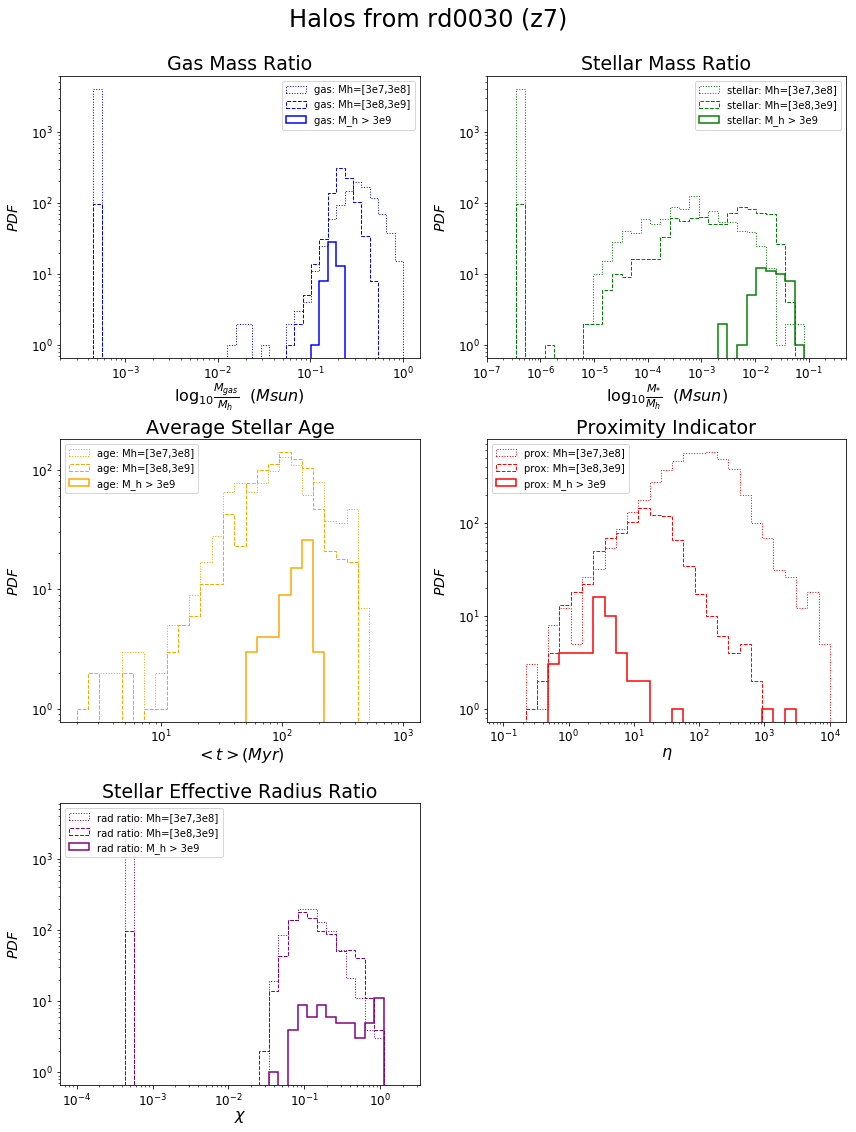

In [567]:
# create subplots
fig1 = plt.figure(figsize = (12,16))
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)

# plot titles
figtitle = "Halos from rd0030 (z7)"
gastitle = "Gas Mass Ratio"
stellartitle = "Stellar Mass Ratio"
agetitle = "Average Stellar Age"
proxtitle = "Proximity Indicator"
radtitle = "Stellar Effective Radius Ratio"

# plot various lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(new_ratiolist11, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax1.hist(new_ratiolist12, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax1.hist(new_ratiolist13, gasbins, ec = 'blue', lw = 1.5, label = 'gas: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax2.hist(new_ratiolist21, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax2.hist(new_ratiolist22, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax2.hist(new_ratiolist23, stelbins, ec = 'green', lw = 1.5, label = 'stellar: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax3.hist(ave_agelist1, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax3.hist(ave_agelist2, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax3.hist(ave_agelist3, agebins, ec = 'orange', lw = 1.5, label = 'age: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax4.hist(proxlist1, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax4.hist(proxlist2, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax4.hist(proxlist3, proxbins, ec = 'red', lw = 1.5, label = 'prox: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax5.hist(rad_ratiolist1, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax5.hist(rad_ratiolist2, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax5.hist(rad_ratiolist3, radbins, ec = 'purple', lw = 1.5, label = 'rad ratio: M_h > 3e9', linestyle = "-", histtype='step', fill = False)

# set title
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(gastitle, size = 19)
ax2.set_title(stellartitle, size = 19)
ax3.set_title(agetitle, size = 19)
ax4.set_title(proxtitle, size = 19)
ax5.set_title(radtitle, size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
gaslab = r"$\log_{10}\frac{M_{gas}}{M_h}$  $(Msun)$"
stellab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
agelab = r"$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
ylab = "$PDF$"
ax1.set_xlabel(gaslab, size = 16, labelpad= 0)
ax2.set_xlabel(stellab, size = 16, labelpad= 0)
ax3.set_xlabel(agelab, size = 16, labelpad= 0)
ax4.set_xlabel(proxlab, size = 16, labelpad= 0)
ax5.set_xlabel(radlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax2.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax3.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax4.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax5.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.tick_params(axis='x', which='major', labelsize=12)
ax5.tick_params(axis='y', which='major', labelsize=12)


# add labels for each plot
# annotation1 = 'using .sum'
# annotation2 = 'using particle mask'
# ax1.text(start, 20, annotation1, size = 12)
# ax2.text(start, 30, annotation2, size = 12)

# set axis limits
ax2.set_xlim([1e-7, 0.5])

# add legend
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
ax5.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig1.subplots_adjust(top=0.92)
plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [564]:
new_logratio21 = np.log([value for value in new_ratiolist21 if value > 0]) / log(10)
new_logratio22 = np.log([value for value in new_ratiolist22 if value > 0]) / log(10)
new_logratio23 = np.log([value for value in new_ratiolist23 if value > 0]) / log(10)

age_log1 = np.log([value for value in ave_agelist1 if value > 0]) / log(10)
age_log2 = np.log([value for value in ave_agelist2 if value > 0]) / log(10)
age_log3 = np.log([value for value in ave_agelist3 if value > 0]) / log(10)
plot_agelog1 = 3**(age_log1**2)/10
plot_agelog2 = 3**(age_log2**2)/10
plot_agelog3 = 3**(age_log3**2)/10

In [506]:
plot_agelog1

array([  7.33183494,   1.39568457,  48.39077363, ...,   0.1       ,
         0.1       ,   0.1       ])

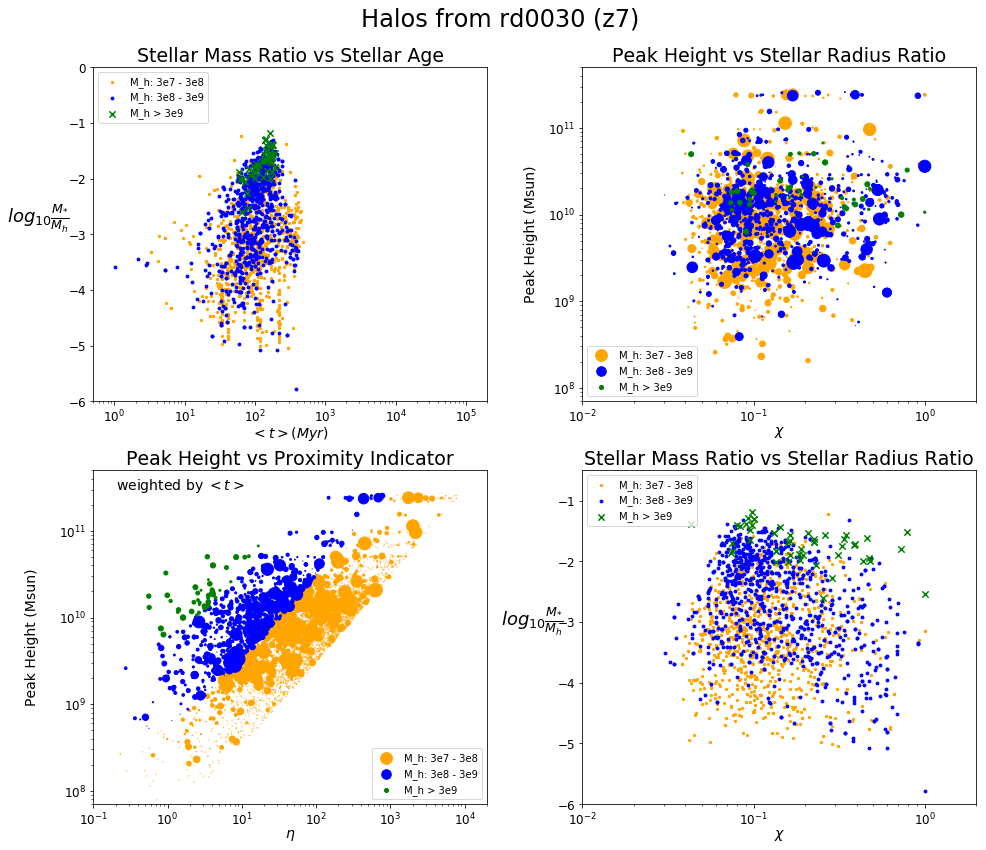

In [565]:
# specify figure size
fig2 = plt.figure(figsize=(14,12))
ax1 = fig2.add_subplot(221)
ax2 = fig2.add_subplot(222)
ax3 = fig2.add_subplot(223)
ax4 = fig2.add_subplot(224)

# create plot titles
agetitle = "Stellar Mass Ratio vs Stellar Age"
peaktitle = "Peak Height vs Stellar Radius Ratio"
proxpeaktitle = "Peak Height vs Proximity Indicator"
radratiotitle = "Stellar Mass Ratio vs Stellar Radius Ratio"

# set titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(peaktitle, size = 19)
ax3.set_title(proxpeaktitle, size = 19)
ax4.set_title(radratiotitle, size = 19)

# # --determine line of best fit
# # reduce range of values to fit line
# bin_edges_fit1 = bin_edges1[8:-10]
# bin_edges_fit2 = bin_edges2[16:-4]
# log_density_fit1 = log_density1[7:-10]
# log_density_fit2 = log_density2[15:-4]
# # determine line
# par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
# par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
# slope1, intercept1 = par1[0][0], par1[0][1]
# slope2, intercept2 = par2[0][0], par2[0][1]

# plot data 
ax1.scatter(ave_agelist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax1.scatter(ave_agelist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax1.scatter(ave_agelist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')

ax2.scatter(rad_ratiolist1, new_peaklist1, c = 'orange', s = plot_agelog1, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax2.scatter(rad_ratiolist2, new_peaklist2, c = 'blue', s = plot_agelog2, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax2.scatter(rad_ratiolist3, new_peaklist3, c = 'green', s = plot_agelog3, cmap='binary', label = 'M_h > 3e9')

ax3.scatter(proxlist1, new_peaklist1, c = 'orange', s = plot_agelog1, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax3.scatter(proxlist2, new_peaklist2, c = 'blue', s = plot_agelog2, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax3.scatter(proxlist3, new_peaklist3, c = 'green', s = plot_agelog3, cmap='binary', label = 'M_h > 3e9')

ax4.scatter(rad_ratiolist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax4.scatter(rad_ratiolist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax4.scatter(rad_ratiolist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
# ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
# ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')

# create axis labels
agelab = "$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
peaklab = "Peak Height (Msun)"
ylab = r"$log_{10}\frac{M_{*}}{M_h}$"
ax1.set_xlabel(agelab, size = 14, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 30)
ax2.set_xlabel(radlab, size = 14, labelpad= 0)
ax2.set_ylabel(peaklab, rotation = 90, size = 14, labelpad= 10)
ax3.set_xlabel(proxlab, size = 14, labelpad= 0)
ax3.set_ylabel(peaklab, rotation = 90, size = 14, labelpad= 20)
ax4.set_xlabel(radlab, size = 14, labelpad= 0)
ax4.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 25)

# create axis ticks and set axis lim
ax1.set_xscale('log')
ax1.set_xlim([5e-1, 2e5])
ax1.set_ylim([-6, 0])
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-2, 2e0])
ax2.set_ylim([7e7, 5e11])
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e-1,2e4])
ax3.set_ylim([7e7, 5e11])
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)

ax4.set_xscale('log')
ax4.set_xlim([1e-2, 2e0])
ax4.set_ylim([-6, -0.5])
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

# add annotation
annotation = r"weighted by $<t>$"
ax3.text(2e-1, 3e11, annotation, size = 14)

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower right')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig2.subplots_adjust(top=0.91)
plt.show()

# 7-12, 26-27, 24-32, 45-53

In [452]:
# convert lists to np arrays
ratioarray1 = np.array(new_ratiolist21)
ratioarray2 = np.array(new_ratiolist22)
ratioarray3 = np.array(new_ratiolist23)
agelog1 = np.log(ave_agelist1) / log(10)
agelog2 = np.log(ave_agelist2) / log(10)
agelog3 = np.log(ave_agelist3) / log(10)


# find stdev for lists
stdevratio1 = np.std(new_logratio21[new_logratio21 > -6])
stdevratio2 = np.std(new_logratio22[new_logratio22 > -6])
stdevratio3 = np.std(new_logratio23[new_logratio23 > -6])

stdevage1 = np.std(agelog1[0 < agelog1])
stdevage2 = np.std(agelog2[0 < agelog2])
stdevage3 = np.std(agelog3[0 < agelog3])

# find mean and medians for lists
meanratio1 = np.mean(new_logratio21[new_logratio21 > -6])
meanratio2 = np.mean(new_logratio22[new_logratio22 > -6])
meanratio3 = np.median(new_logratio23[new_logratio23 > -6])

meanage1 = np.mean(agelog1[0 < agelog1])
meanage2 = np.mean(agelog2[0 < agelog2])
meanage3 = np.median(agelog3[0 < agelog3])

In [453]:
# create corresp lists of stdev, mean, medians
masslist = [3e7, 3e8, 3e9]

ratiodevlist = [stdevratio1, stdevratio2, stdevratio3]
agedevlist = [stdevage1, stdevage2, stdevage3]

ratiomeanlist = [meanratio1, meanratio2, meanratio3]
agemeanlist = [meanage1, meanage2, meanage3]

In [454]:
print(ratiomeanlist)
print(ratiodevlist)
print(agemeanlist)
print(agedevlist)

[-3.2843315191123574, -2.7556128891453073, -1.6853447916460855]
[0.75109745779841497, 0.80332221129882297, 0.33013826980324279]
[1.9450679701195561, 1.9645075383044319, 2.1437796633831536]
[0.34897049894105231, 0.28450211613852616, 0.1417706779145414]


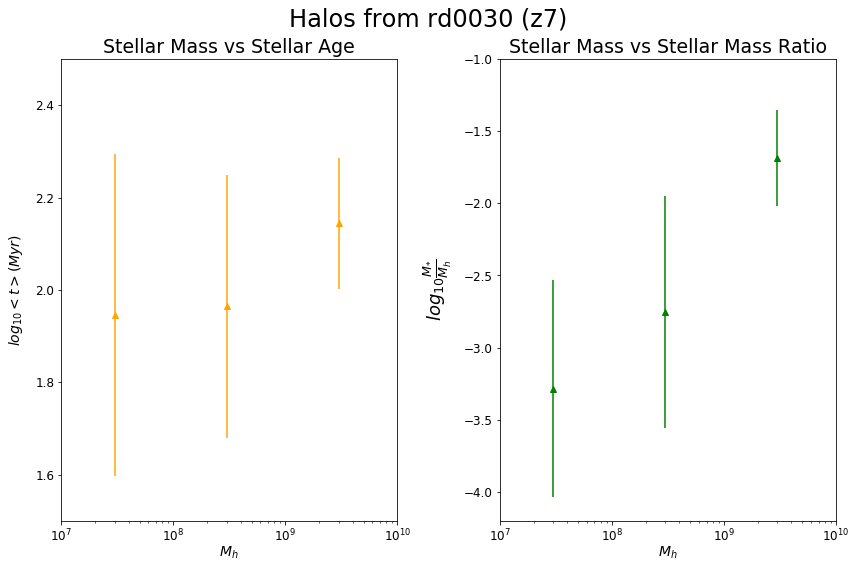

In [463]:
# specify figure size
fig3 = plt.figure(figsize=(12,8))
ax1 = fig3.add_subplot(121)
ax2 = fig3.add_subplot(122)

# create plot titles
agetitle = "Stellar Mass vs Stellar Age"
massratiotitle = "Stellar Mass vs Stellar Mass Ratio"

# set plot titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(massratiotitle, size = 19)

# create plots
ax1.errorbar(masslist, agemeanlist, agedevlist, c = 'orange', marker="^", linestyle='None')
ax2.errorbar(masslist, ratiomeanlist, ratiodevlist, c = 'green', marker="^", linestyle='None')

# create axis labels
agelab = "$log_{10}<t> (Myr)$"
ratiolab = r"$log_{10}\frac{M_{*}}{M_h}$"
masslab = r"$M_h$"
ax1.set_xlabel(masslab, size = 14, labelpad= 0)
ax1.set_ylabel(agelab, rotation = 90, size = 14, labelpad= 10)
ax2.set_xlabel(masslab, size = 14, labelpad= 0)
ax2.set_ylabel(ratiolab, rotation = 90, size = 18, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# set axis limits
ax1.set_xlim([1e7, 1e10])
ax1.set_ylim([1.5, 2.5])
ax2.set_xlim([1e7, 1e10])
ax2.set_ylim([-4.2, -1])

# adjust spacing and show
plt.tight_layout()
fig3.subplots_adjust(top=0.89)
plt.show()

In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

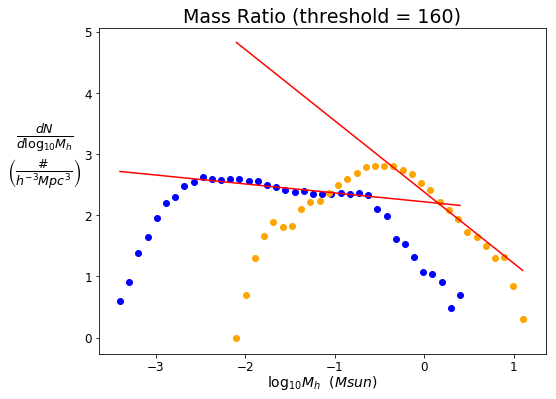

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()

In [578]:
list1 = [1,2]
list2 = [3,4]

In [576]:
list3 = [list1, list2]
list3[0][1] = 3

In [571]:
list3 = [5,6]
list1

[1, 3]

In [579]:
list3

[[1, 3], [3, 4]]